In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import os
from importlib import reload

import torch
import numpy as np
import sciplots as plots
from sciplots import misc, utils
from netloader.data import loader_init
from netloader.utils.utils import get_device

from src.utils import plot_config
from src.utils.data import DarkDataset
from src.utils.utils import open_config
from src.utils.clustering import CompactClusterEncoder

reload(misc)
reload(plots)

import sciplots as plots

torch.serialization.add_safe_globals([CompactClusterEncoder])

In [4]:
_, config = open_config('main', '../config.yaml')

net_epochs = config['training']['epochs']
states_dir = config['output']['network-states-directory']
plots_dir = config['output']['plots-directory']
colours = np.array(plot_config.BAHAMAS_AGN + plot_config.BAHAMAS)

In [5]:
torch.manual_seed(0)
np.random.seed(0)
known = [
    'bahamas_cdm',
    'bahamas_0.1',
    'bahamas_0.3',
    'bahamas_1',
    'bahamas_dmo_0.1',
]
unknown = [
]

dataset = DarkDataset(config['data']['data-dir'], known, unknown)
dataset.low_dim = dataset.unique_labels(dataset.low_dim, dataset.extra['sims'])

net = torch.load(os.path.join(config['output']['network-states-directory'], 'network_v8_49.3.0.pth'), weights_only=False)
net.to(get_device()[1])
net.transforms['inputs'][1]._shape = dataset.high_dim.shape[1:]
dataset.high_dim = net.transforms['inputs'](dataset.high_dim)
dataset.low_dim = net.transforms['targets'](dataset.low_dim)
print(net)

loaders = loader_init(
    dataset,
    batch_size=config['training']['batch-size'],
    ratios=(1 - config['training']['validation-fraction'], config['training']['validation-fraction']) if net.idxs is None else (1,),
    idxs=None if net.idxs is None else dataset.idxs[np.isin(dataset.extra['ids'], net.idxs)],
)

data = net.saliency(loaders[1])
data['saliencies'].shape

Architecture: CompactClusterEncoder
Description: DARKSKIES-0.2, DARKSKIES-0.1, Final Large Net, Flamingo, (K 1e-2, NX, 1L)
Network: network_v8
Epoch: 150
Optimiser: AdamW
Scheduler: ReduceLROnPlateau
Args: (method: median, center_step: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], similarity_weight: 0, class_weight: 1, compact_weight: 0, distance_weight: 1, steps: 3, cluster_weight: 2.2)


(120, 7, 1, 100, 100)

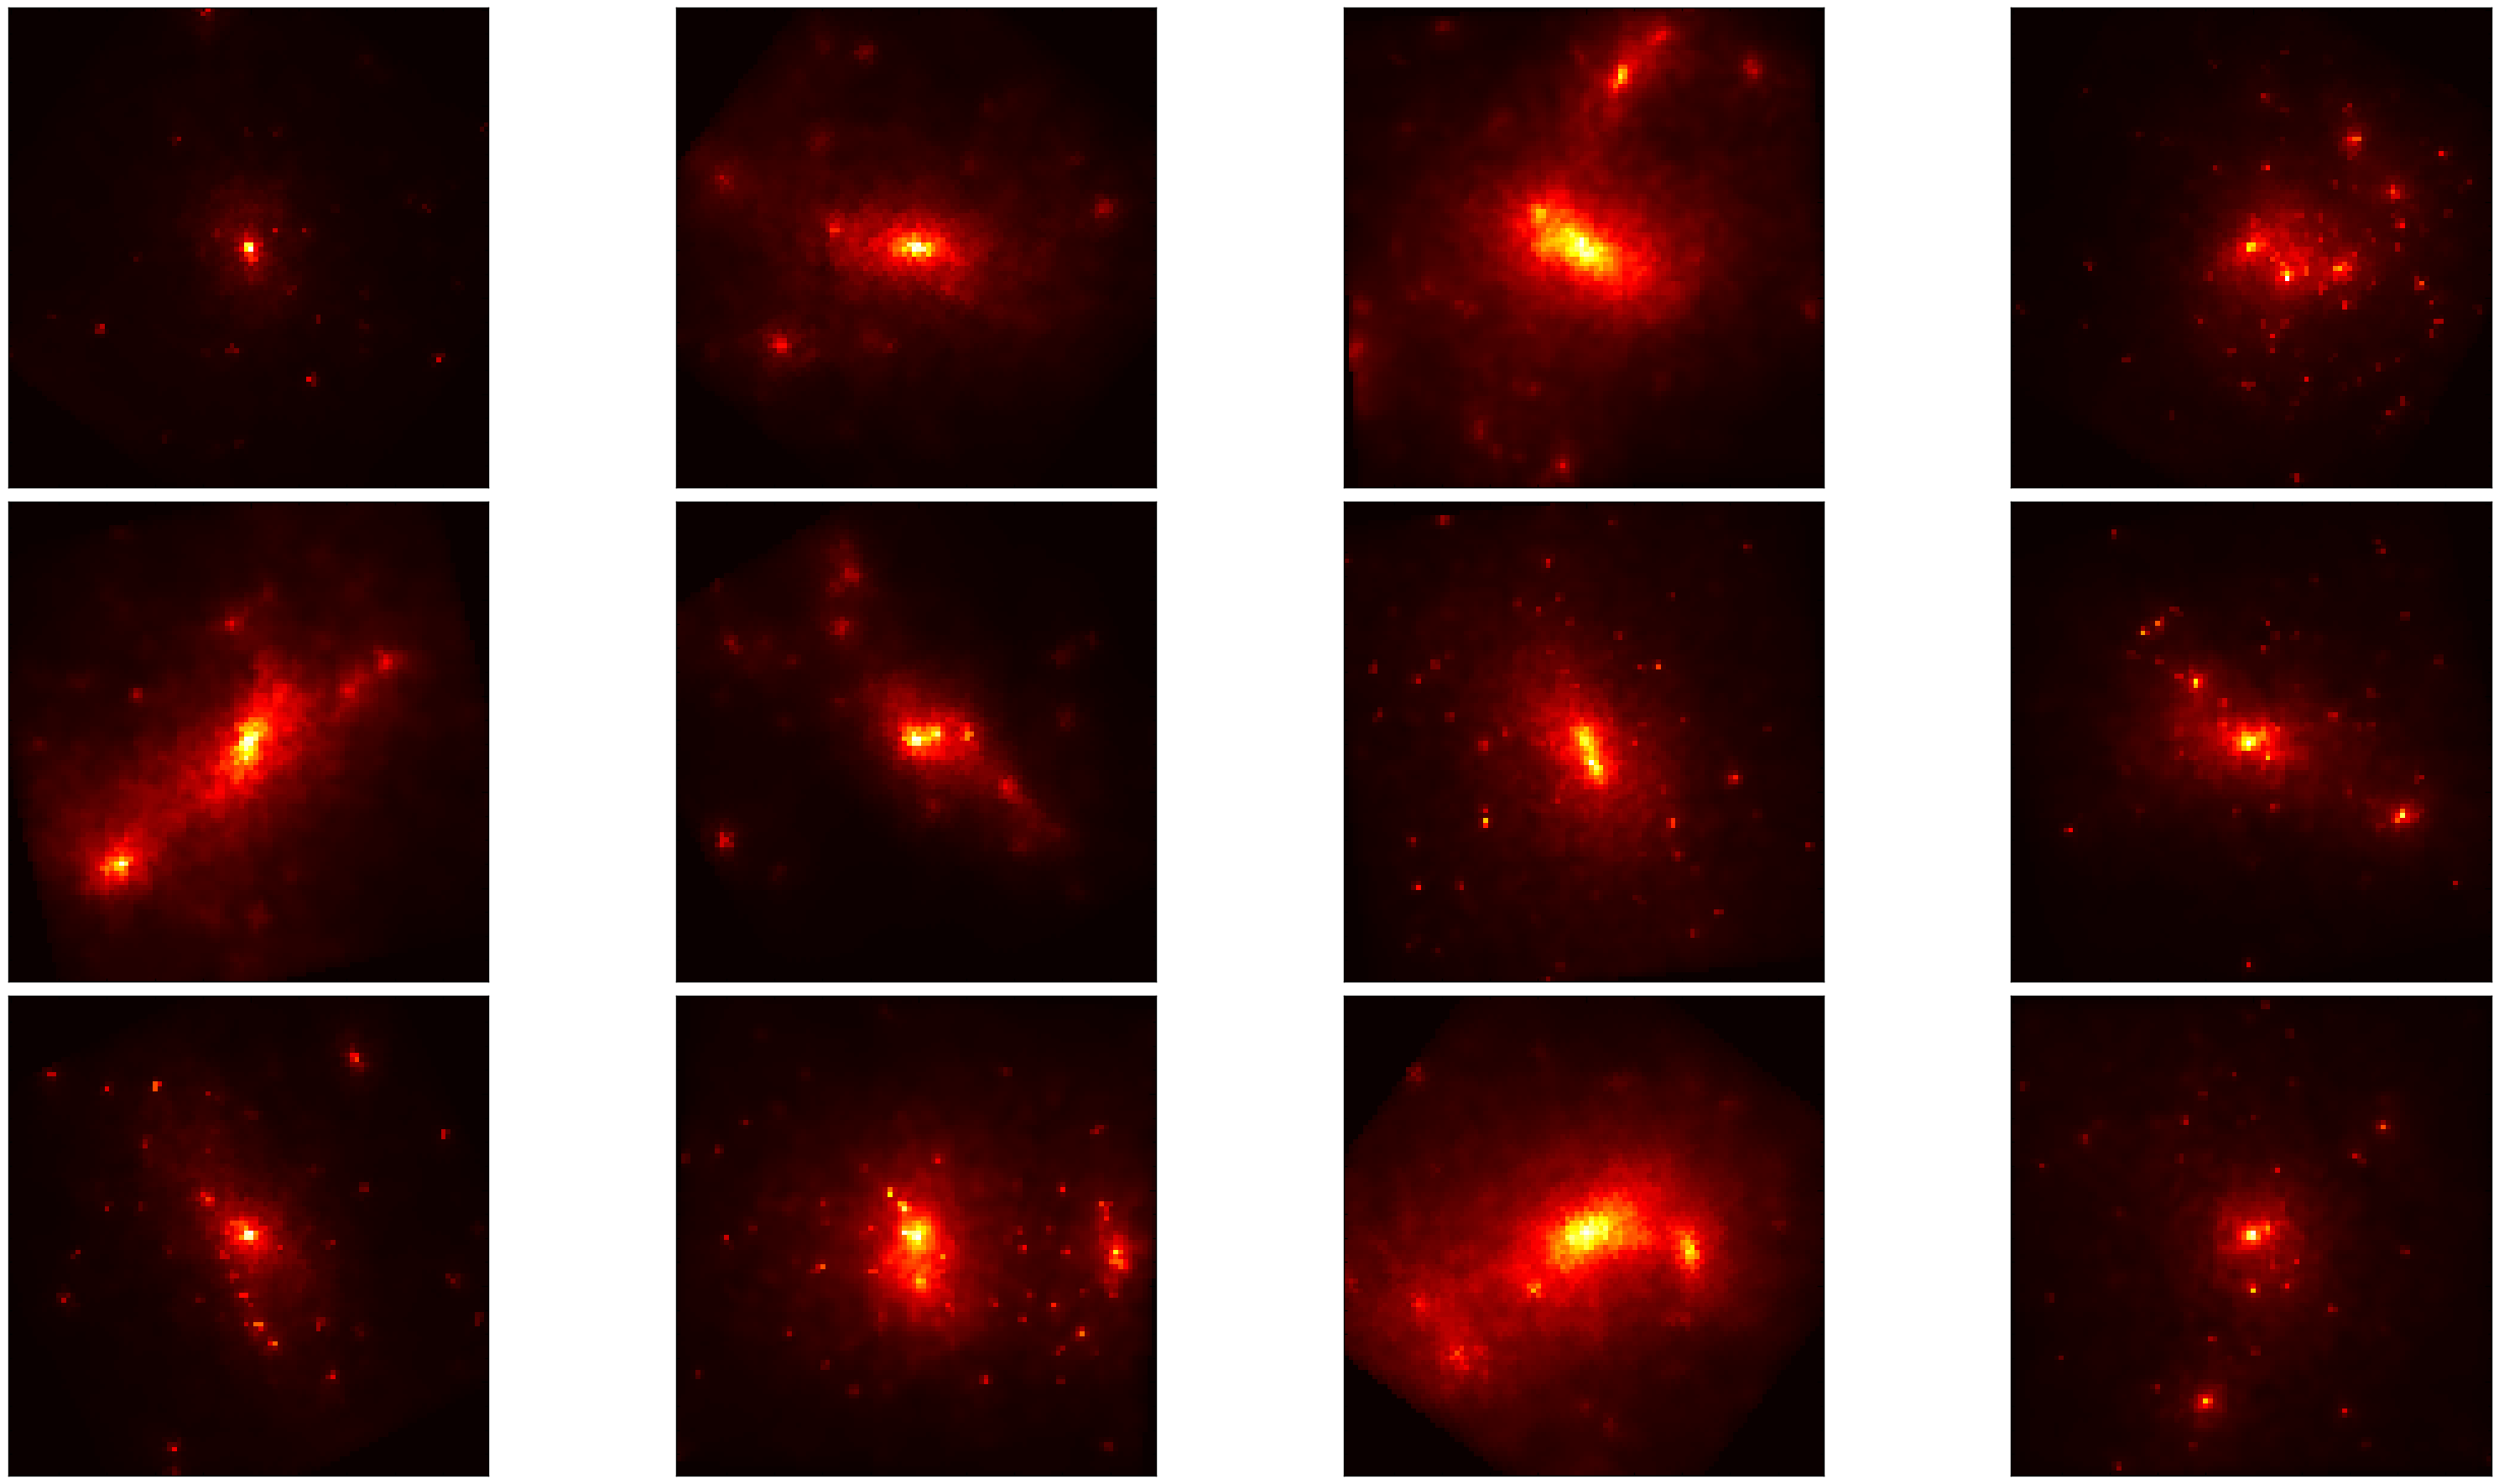

In [27]:
plots.PlotImages(data['inputs'][12:24, 0])

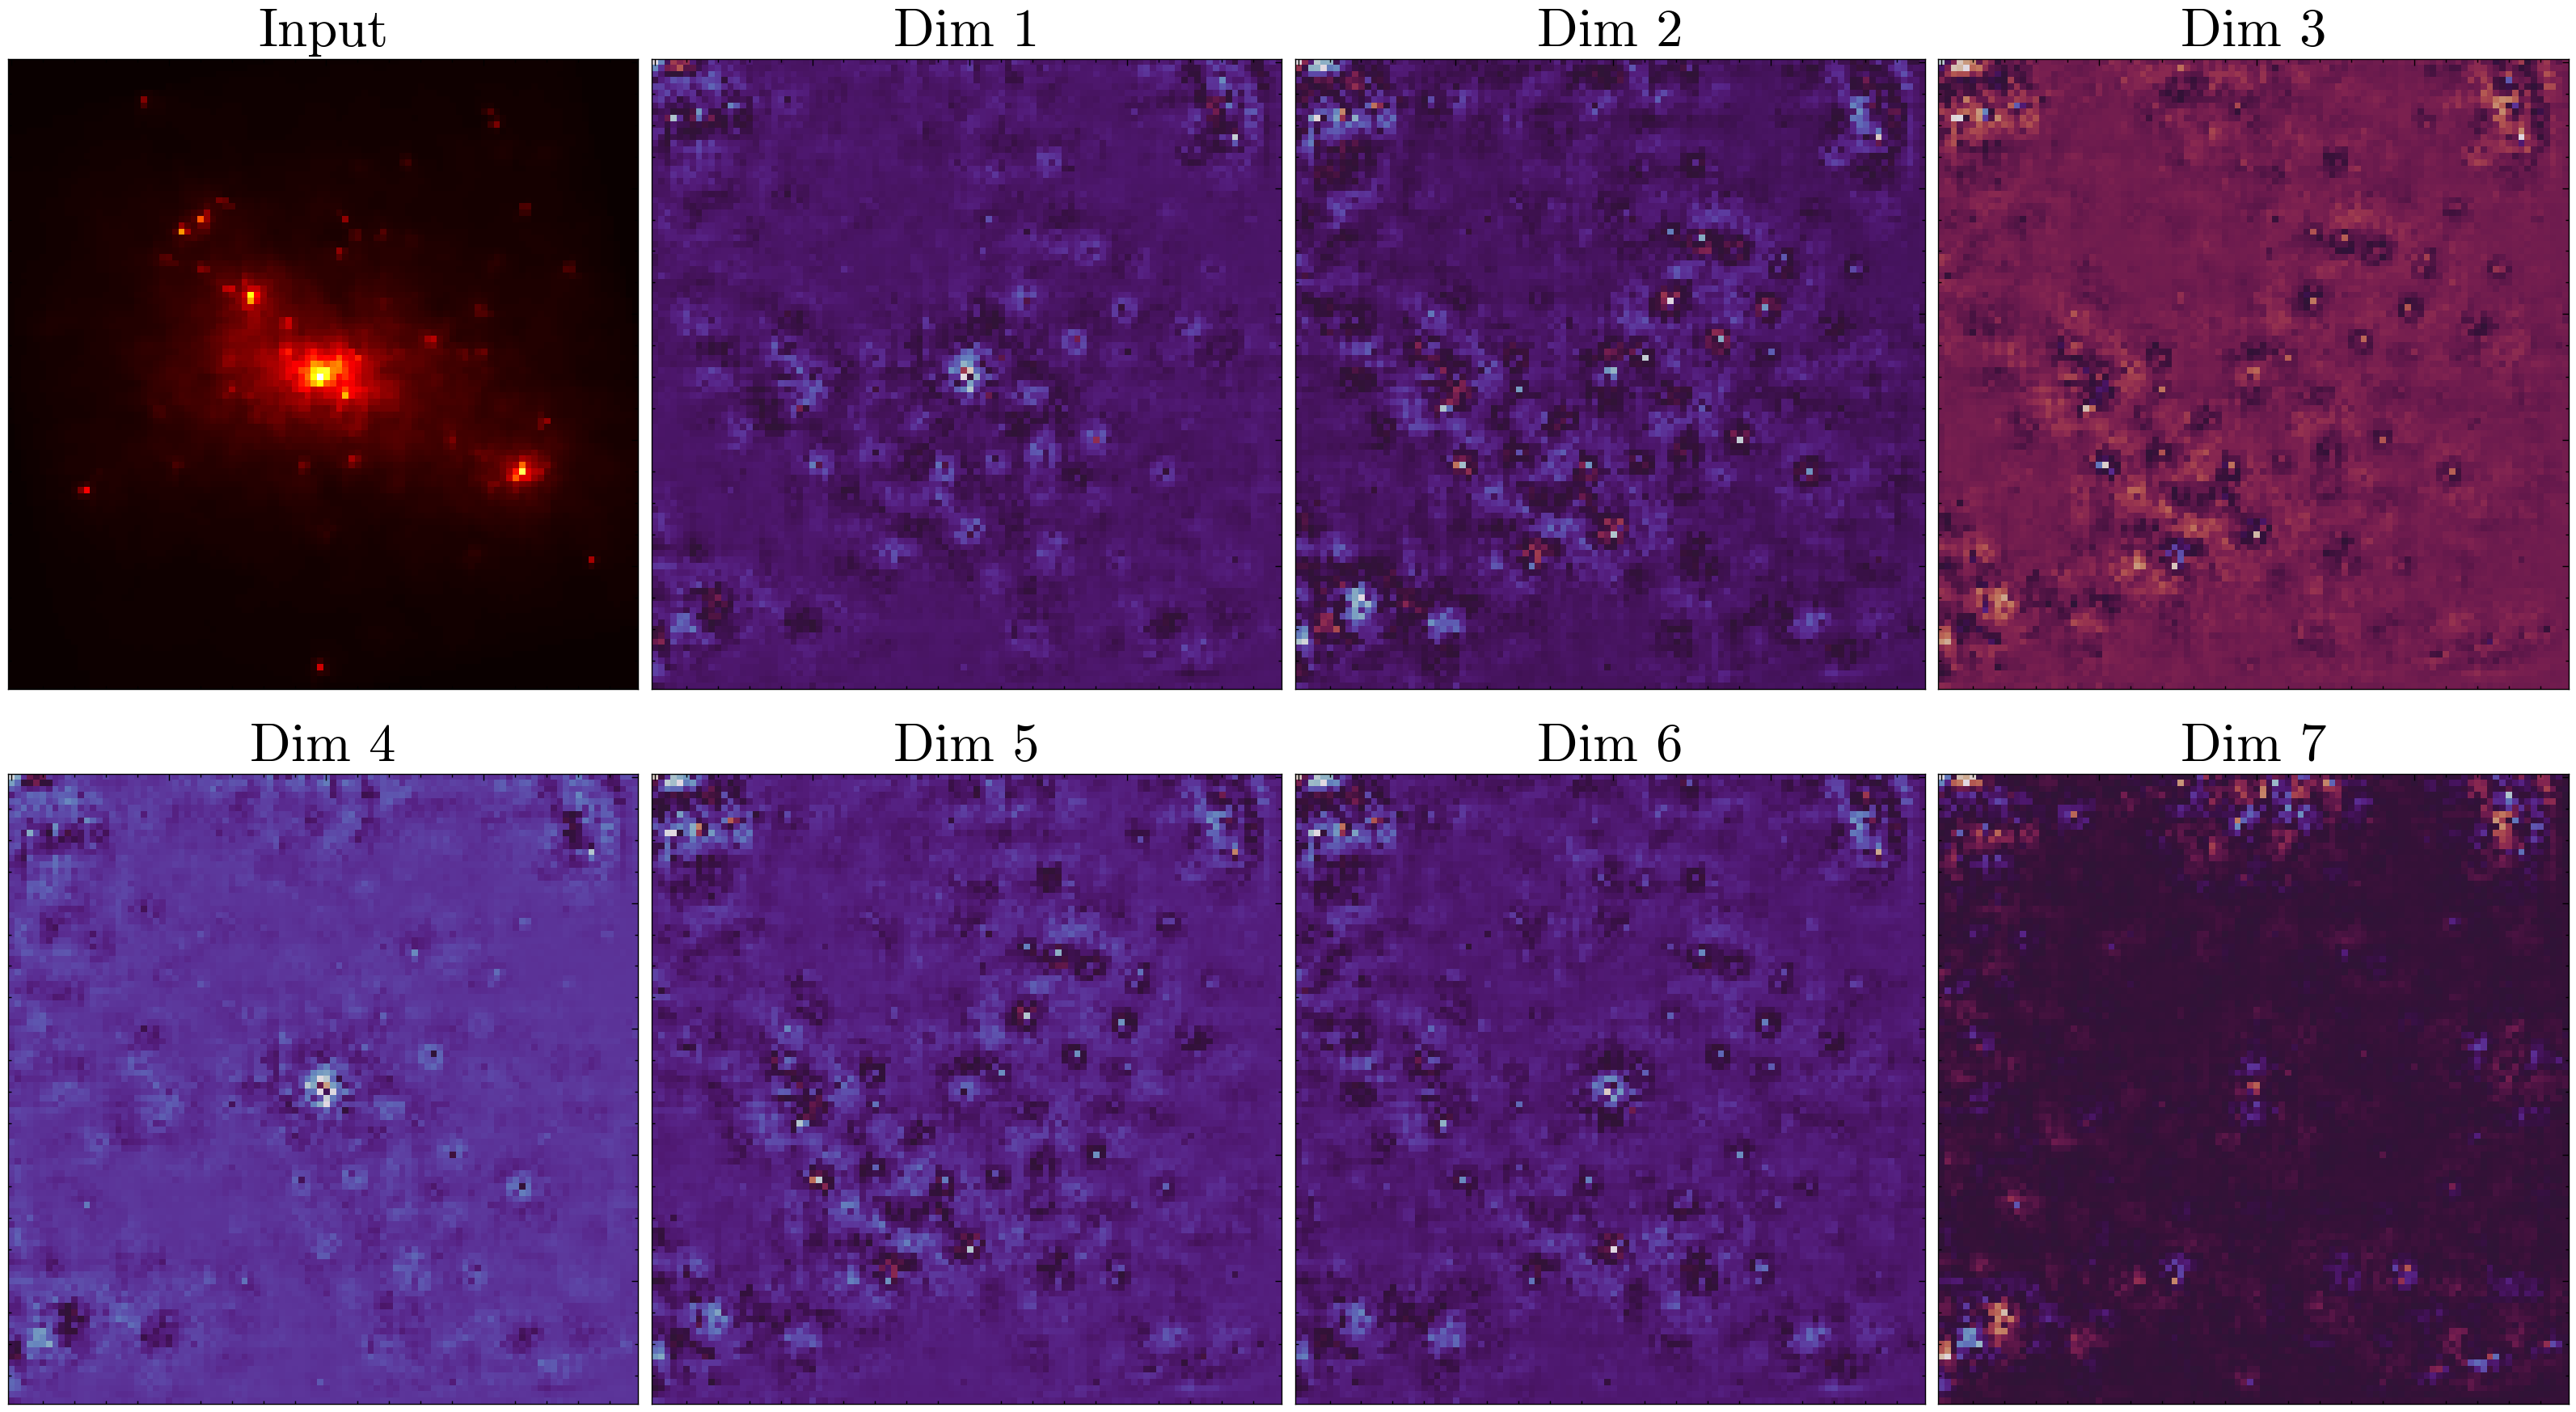

In [28]:
# plots.PlotImages(saliencies['saliencies'][0, :, 0], cmaps='twilight')
idx = 19
plot = plots.PlotSaliency(data['inputs'][idx, 0], data['saliencies'][idx, :, 0])

In [34]:
np.min(data['saliencies'][idx, 3:4, 0])

np.float32(-0.0027520657)

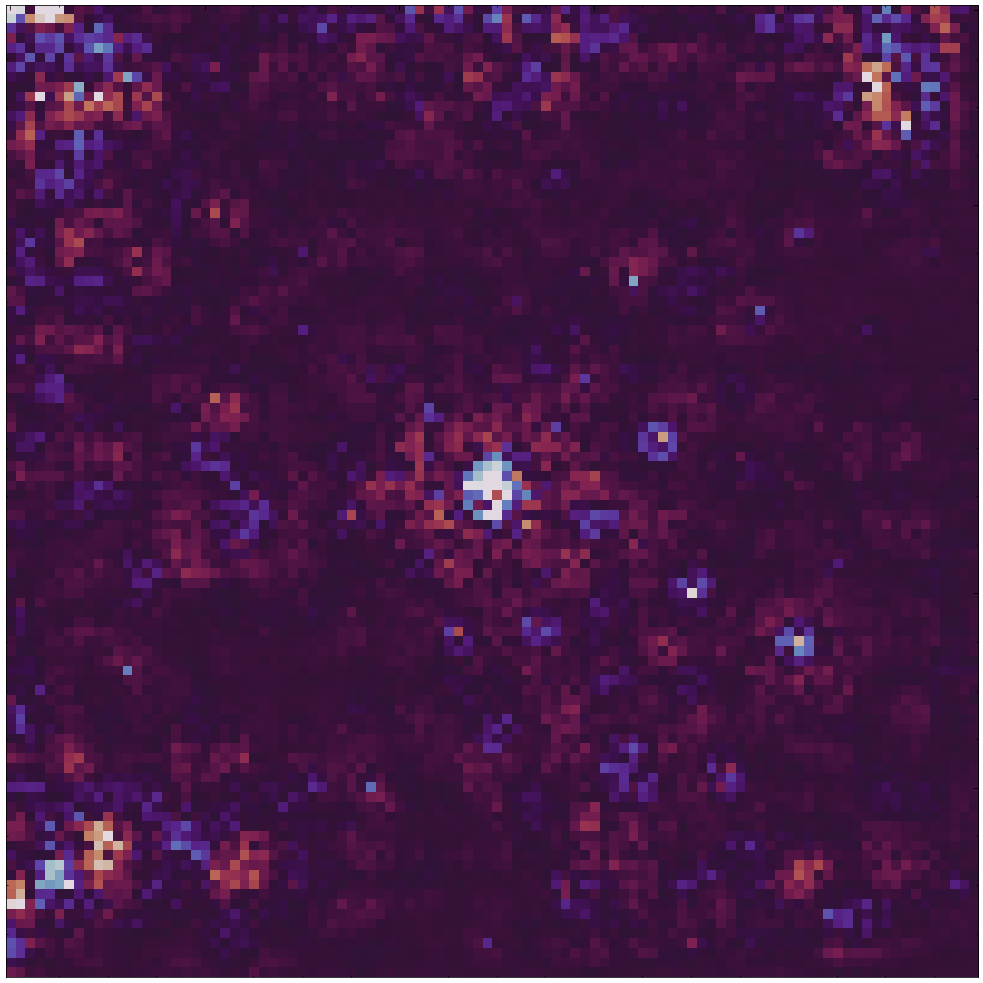

In [37]:
plot = plots.PlotImages(data['saliencies'][idx, 3:4, 0], cmaps='twilight', fig_size=utils.SQUARE, ranges=(np.quantile(data['saliencies'][idx, 3:4, 0], 0.001), np.quantile(data['saliencies'][idx, 3:4, 0], 0.999)))